# 🔍 Financial Fraud Detection — Anomaly Analysis
> **Objective:** Identify suspicious transactions in a financial dataset using unsupervised anomaly detection (Isolation Forest), engineer meaningful fraud signals, and generate actionable security insights.

---
**Dataset:** `transactions.csv` — 2,512 transactions across 16 features  
**Method:** Isolation Forest (unsupervised) + feature engineering  
**Output:** Anomaly scores, flagged transactions, visualisations, and recommendations

## 1 · Setup & Data Loading
Import all required libraries and load the raw transaction dataset.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

# ── Style ──────────────────────────────────────────────────────────────────
plt.rcParams.update({
    'figure.facecolor': '#0F1117',
    'axes.facecolor':   '#1A1D27',
    'axes.edgecolor':   '#2E3147',
    'axes.labelcolor':  '#C0C5D0',
    'xtick.color':      '#8A8FA8',
    'ytick.color':      '#8A8FA8',
    'text.color':       'white',
    'grid.color':       '#2E3147',
    'grid.linestyle':   '--',
    'grid.alpha':       0.5,
    'axes.grid':        True,
})

BLUE  = '#4F9EF8'
RED   = '#FF4B6E'
GREEN = '#36D399'
GOLD  = '#F6C90E'

print('Libraries loaded.')

Libraries loaded.


In [4]:
# ── Load data ──────────────────────────────────────────────────────────────
transactions = pd.read_csv('transactions.csv')

print(f'Shape: {transactions.shape}')
print(f'Columns: {list(transactions.columns)}')
transactions.head()

Shape: (2512, 16)
Columns: ['TransactionID', 'AccountID', 'TransactionAmount', 'TransactionDate', 'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID', 'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate']


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


## 2 · Exploratory Data Analysis (EDA)
Understand the dataset structure, distributions, and any immediate anomalous patterns before modelling.

In [5]:
# ── Basic statistics ───────────────────────────────────────────────────────
print('=== Missing values ===')
print(transactions.isnull().sum())

print('\n=== Numeric summary ===')
transactions[['TransactionAmount','TransactionDuration','LoginAttempts','AccountBalance']].describe().round(2)

=== Missing values ===
TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64

=== Numeric summary ===


,TransactionAmount,TransactionDuration,LoginAttempts,AccountBalance
count,2512.00,2512.00,2512.00,2512.00
mean,297.59,119.64,1.12,5114.30
std,291.95,69.96,0.60,3900.94
min,0.26,10.00,1.00,101.25
25%,81.89,63.00,1.00,1504.37
50%,211.14,112.50,1.00,4735.51
75%,414.53,161.00,1.00,7678.82
max,1919.11,300.00,5.00,14977.99


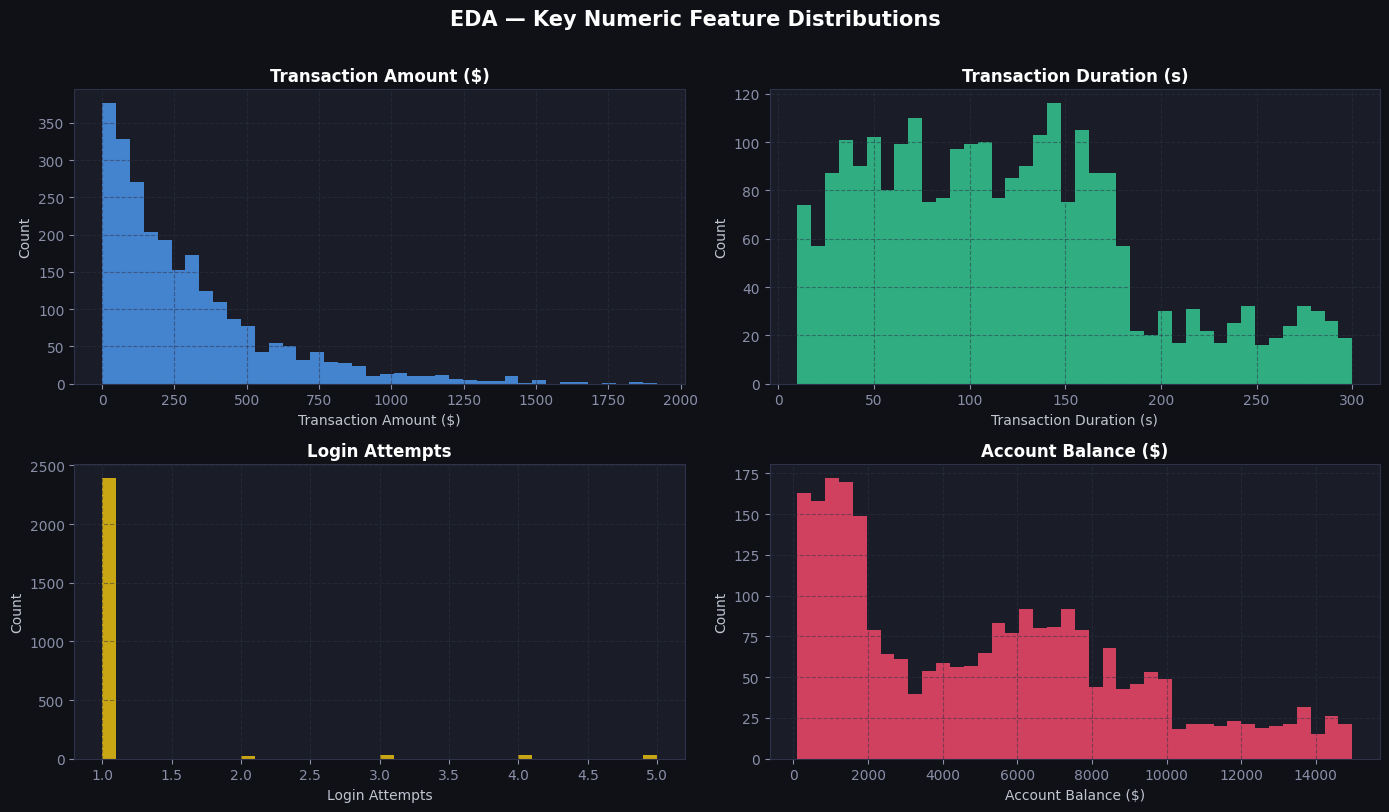

EDA chart saved.


In [6]:
# ── Distribution overview ──────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('EDA — Key Numeric Feature Distributions', fontsize=15, fontweight='bold', color='white', y=1.01)

cols  = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
titles = ['Transaction Amount ($)', 'Transaction Duration (s)', 'Login Attempts', 'Account Balance ($)']
colors = [BLUE, GREEN, GOLD, RED]

for ax, col, title, c in zip(axes.flat, cols, titles, colors):
    ax.hist(transactions[col], bins=40, color=c, alpha=0.8, edgecolor='none')
    ax.set_title(title, color='white', fontweight='bold')
    ax.set_xlabel(title)
    ax.set_ylabel('Count')

plt.tight_layout()
plt.savefig('eda_distributions.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()
print('EDA chart saved.')

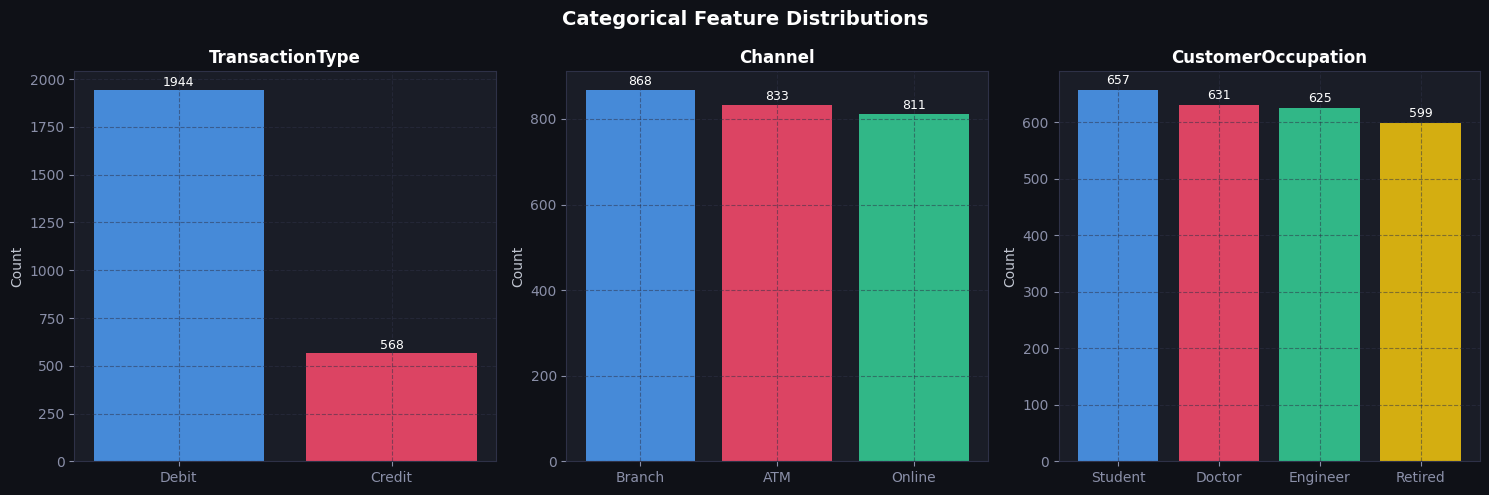

In [7]:
# ── Categorical breakdowns ─────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Categorical Feature Distributions', fontsize=14, fontweight='bold', color='white')

cat_cols  = ['TransactionType', 'Channel', 'CustomerOccupation']
for ax, col in zip(axes, cat_cols):
    vc = transactions[col].value_counts()
    bars = ax.bar(vc.index, vc.values, color=[BLUE, RED, GREEN, GOLD, '#A78BFA'][:len(vc)], alpha=0.85)
    ax.set_title(col, fontweight='bold', color='white')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                str(bar.get_height()), ha='center', va='bottom', fontsize=9, color='white')

plt.tight_layout()
plt.savefig('eda_categorical.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()

## 3 · Feature Engineering
Derive additional fraud-signal features before passing data to the model.

| Feature | Rationale |
|---|---|
| `Amount_to_Balance_Ratio` | Large spend relative to balance is a strong fraud indicator |
| `Hour` | Off-hours transactions (late night / early morning) are riskier |
| `HighLoginAttempts` | >1 attempt suggests credential stuffing or account takeover |

In [8]:
# ── Parse dates ────────────────────────────────────────────────────────────
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# ── Engineered features ─────────────────────────────────────────────────────
transactions['Amount_to_Balance_Ratio'] = (
    transactions['TransactionAmount'] /
    transactions['AccountBalance'].replace(0, np.nan)
).fillna(0)

transactions['Hour'] = transactions['TransactionDate'].dt.hour
transactions['DayOfWeek'] = transactions['TransactionDate'].dt.dayofweek  # 0=Mon, 6=Sun
transactions['HighLoginAttempts'] = (transactions['LoginAttempts'] > 1).astype(int)

print('New features added:')
print(transactions[['Amount_to_Balance_Ratio','Hour','DayOfWeek','HighLoginAttempts']].describe().round(3))

New features added:
       Amount_to_Balance_Ratio      Hour  DayOfWeek  HighLoginAttempts
count                 2512.000  2512.000   2512.000           2512.000
mean                     0.200    16.626      1.448              0.049
std                      0.512     0.731      1.511              0.215
min                      0.000    16.000      0.000              0.000
25%                      0.018    16.000      0.000              0.000
50%                      0.052    16.000      1.000              0.000
75%                      0.152    17.000      3.000              0.000
max                      7.896    18.000      4.000              1.000


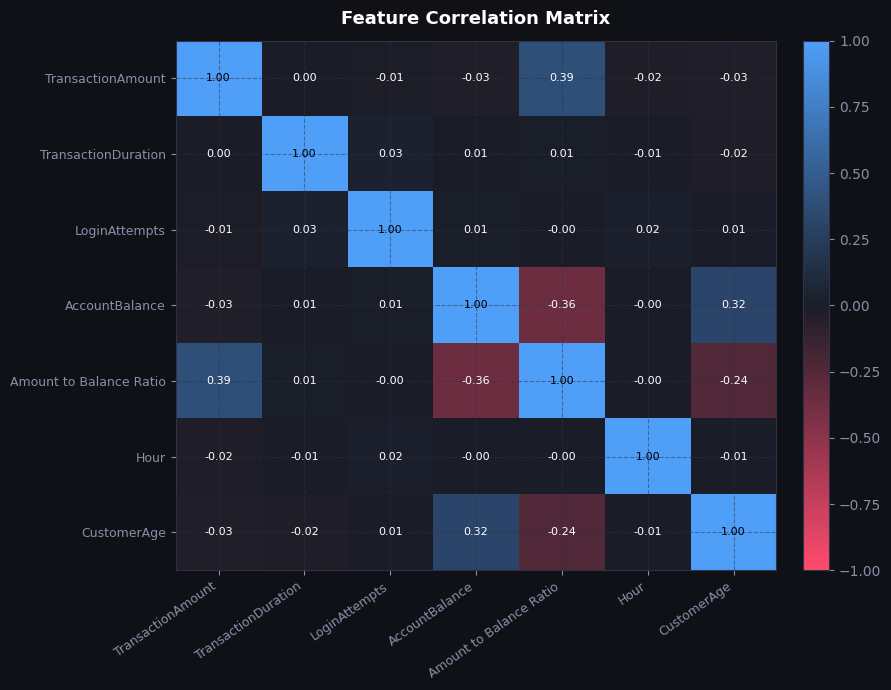

In [9]:
# ── Correlation heatmap of numeric features ────────────────────────────────
import matplotlib.colors as mcolors

num_cols = ['TransactionAmount','TransactionDuration','LoginAttempts',
            'AccountBalance','Amount_to_Balance_Ratio','Hour','CustomerAge']
corr = transactions[num_cols].corr()

fig, ax = plt.subplots(figsize=(9, 7))
cmap = LinearSegmentedColormap.from_list('rg', ['#FF4B6E','#1A1D27','#4F9EF8'], N=256)
im = ax.imshow(corr.values, cmap=cmap, vmin=-1, vmax=1, aspect='auto')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xticks(range(len(num_cols)))
ax.set_yticks(range(len(num_cols)))
ax.set_xticklabels([c.replace('_',' ') for c in num_cols], rotation=35, ha='right', fontsize=9)
ax.set_yticklabels([c.replace('_',' ') for c in num_cols], fontsize=9)
for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        ax.text(j, i, f'{corr.values[i,j]:.2f}', ha='center', va='center',
                fontsize=8, color='white' if abs(corr.values[i,j]) < 0.5 else 'black')
ax.set_title('Feature Correlation Matrix', fontsize=13, fontweight='bold', color='white', pad=12)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()

## 4 · Anomaly Detection — Isolation Forest
**Isolation Forest** detects anomalies by randomly partitioning the feature space. Points that are easier to isolate (fewer splits needed) receive higher anomaly scores — ideal for fraud detection because fraudulent transactions are typically rare and structurally distinct.

**Hyperparameters:**
- `n_estimators=200` — 200 trees for stable scoring
- `contamination=0.05` — assume ~5% of transactions are fraudulent
- `random_state=42` — reproducible results

In [10]:
# ── Feature matrix ─────────────────────────────────────────────────────────
features = [
    'TransactionAmount',
    'TransactionDuration',
    'LoginAttempts',
    'AccountBalance',
    'Amount_to_Balance_Ratio',
    'Hour'
]

X = transactions[features].copy()
scaler  = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ── Train Isolation Forest ──────────────────────────────────────────────────
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    random_state=42,
    max_features=1.0
)
iso_forest.fit(X_scaled)

# ── Compute & normalise anomaly scores ──────────────────────────────────────
raw_scores = iso_forest.score_samples(X_scaled)          # more negative = more anomalous
min_s, max_s = raw_scores.min(), raw_scores.max()
transactions['Anomaly_Score'] = (max_s - raw_scores) / (max_s - min_s)  # normalise to [0,1]

# ── Boolean anomaly flag ────────────────────────────────────────────────────
transactions['Anomaly'] = iso_forest.predict(X_scaled) == -1

n_anomalies = transactions['Anomaly'].sum()
print(f'Total transactions : {len(transactions):,}')
print(f'Flagged anomalies  : {n_anomalies:,}  ({n_anomalies/len(transactions):.2%})')
print(f'Normal transactions: {(~transactions["Anomaly"]).sum():,}')
print(f'\nAnomaly Score stats (anomalous only):')
print(transactions.loc[transactions['Anomaly'], 'Anomaly_Score'].describe().round(4))

Total transactions : 2,512
Flagged anomalies  : 126  (5.02%)
Normal transactions: 2,386

Anomaly Score stats (anomalous only):
count    126.0000
mean       0.7045
std        0.0843
min        0.5912
25%        0.6493
50%        0.6838
75%        0.7454
max        1.0000
Name: Anomaly_Score, dtype: float64


## 5 · Anomalies Summary
Build a focused DataFrame containing only the flagged transactions with the four key reporting columns.

In [11]:
# ── Anomalies summary DataFrame ────────────────────────────────────────────
anomalies_summary = (
    transactions.loc[
        transactions['Anomaly'],
        ['TransactionID','TransactionAmount','TransactionDuration','AccountBalance']
    ]
    .reset_index(drop=True)
)

print(f'anomalies_summary shape: {anomalies_summary.shape}')
anomalies_summary.head(20)

anomalies_summary shape: (126, 4)


,TransactionID,TransactionAmount,TransactionDuration,AccountBalance
0,TX000014,781.76,123,189.69
1,TX000024,345.84,142,1402.50
2,TX000027,246.93,158,673.35
3,TX000034,877.81,150,399.00
4,TX000075,1212.51,24,605.95
5,TX000148,514.95,142,421.93
6,TX000166,231.91,165,112.76
7,TX000177,1362.55,106,2429.68
8,TX000230,630.24,62,370.81
9,TX000232,705.60,124,14804.70


In [12]:
# ── Statistical comparison: Normal vs Anomalous ─────────────────────────────
comparison_cols = ['TransactionAmount','TransactionDuration','LoginAttempts',
                   'AccountBalance','Amount_to_Balance_Ratio']

comparison = pd.DataFrame({
    'Normal (mean)':   transactions.loc[~transactions['Anomaly'], comparison_cols].mean(),
    'Anomaly (mean)':  transactions.loc[ transactions['Anomaly'], comparison_cols].mean(),
}).round(2)
comparison['% Difference'] = (
    (comparison['Anomaly (mean)'] - comparison['Normal (mean)']) / comparison['Normal (mean)'] * 100
).round(1).astype(str) + '%'

print('=== Mean Feature Comparison ===')
comparison

=== Mean Feature Comparison ===


,Normal (mean),Anomaly (mean),% Difference
TransactionAmount,277.06,686.38,147.7%
TransactionDuration,118.38,143.60,21.3%
LoginAttempts,1.04,2.68,157.7%
AccountBalance,5152.77,4385.90,-14.9%
Amount_to_Balance_Ratio,0.15,1.17,680.0%


In [13]:
# ── Top 15 highest-risk transactions ───────────────────────────────────────
top_anomalies = (
    transactions.loc[transactions['Anomaly']]
    .nlargest(15, 'Anomaly_Score')
    [['TransactionID','TransactionAmount','TransactionDuration',
      'LoginAttempts','AccountBalance','Amount_to_Balance_Ratio','Anomaly_Score']]
    .reset_index(drop=True)
)
top_anomalies.style.background_gradient(subset=['Anomaly_Score'], cmap='YlOrRd')

,TransactionID,TransactionAmount,TransactionDuration,LoginAttempts,AccountBalance,Amount_to_Balance_Ratio,Anomaly_Score
0,TX000275,1176.280000,174,5,323.690000,3.633971,1.000000
1,TX000899,1531.310000,62,4,859.860000,1.780883,0.998677
2,TX000455,611.110000,282,4,919.840000,0.664366,0.913173
3,TX000615,1342.250000,235,1,694.030000,1.933994,0.900301
4,TX000148,514.950000,142,5,421.930000,1.220463,0.882966
5,TX002087,1192.950000,73,1,325.150000,3.668922,0.864484
6,TX000395,6.300000,283,5,7697.680000,0.000818,0.856911
7,TX002274,806.970000,11,1,102.200000,7.895988,0.851556
8,TX000312,1221.650000,153,1,243.920000,5.008404,0.848032
9,TX000694,733.290000,94,5,10427.000000,0.070326,0.832801


## 6 · Visualisations
A comprehensive visual suite: amount distributions, score distributions, scatter plots, and channel/hour breakdowns.

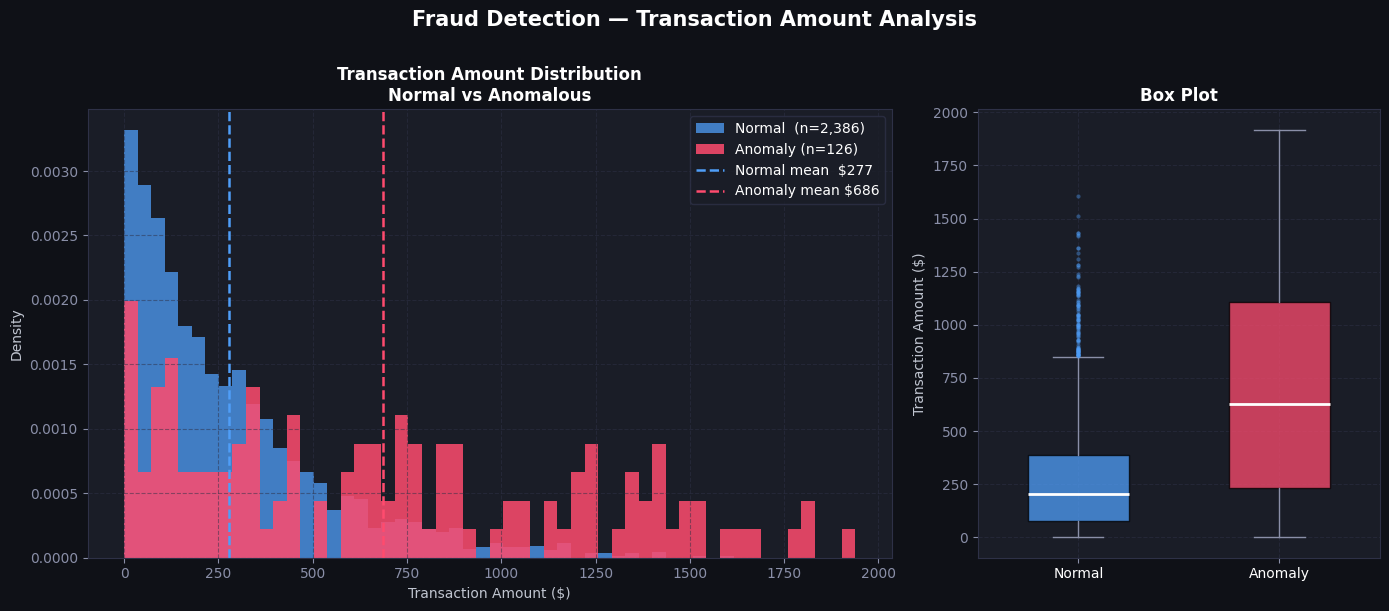

anomalies_histogram.png saved.


In [14]:
# ── 6A  Transaction Amount: Histogram + Box plot ──────────────────────────
normal_amounts  = transactions.loc[~transactions['Anomaly'], 'TransactionAmount']
anomaly_amounts = transactions.loc[ transactions['Anomaly'], 'TransactionAmount']

fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})
fig.patch.set_facecolor('#0F1117')
for ax in axes: ax.set_facecolor('#1A1D27')

bins = np.linspace(0, transactions['TransactionAmount'].max() + 20, 55)
axes[0].hist(normal_amounts,  bins=bins, color=BLUE, alpha=0.75,
             label=f'Normal  (n={len(normal_amounts):,})',  density=True, edgecolor='none')
axes[0].hist(anomaly_amounts, bins=bins, color=RED,  alpha=0.85,
             label=f'Anomaly (n={len(anomaly_amounts):,})', density=True, edgecolor='none')
axes[0].axvline(normal_amounts.mean(),  color=BLUE, lw=1.8, ls='--',
                label=f'Normal mean  ${normal_amounts.mean():.0f}')
axes[0].axvline(anomaly_amounts.mean(), color=RED,  lw=1.8, ls='--',
                label=f'Anomaly mean ${anomaly_amounts.mean():.0f}')
axes[0].set_xlabel('Transaction Amount ($)')
axes[0].set_ylabel('Density')
axes[0].set_title('Transaction Amount Distribution\nNormal vs Anomalous', fontweight='bold', color='white')
axes[0].legend(facecolor='#1A1D27', edgecolor='#2E3147', labelcolor='white', fontsize=10)

bp = axes[1].boxplot([normal_amounts, anomaly_amounts], patch_artist=True, widths=0.5,
    medianprops=dict(color='white', linewidth=2),
    whiskerprops=dict(color='#8A8FA8'), capprops=dict(color='#8A8FA8'),
    flierprops=dict(marker='o', markersize=3, alpha=0.4, markeredgewidth=0))
for patch, c in zip(bp['boxes'], [BLUE, RED]):
    patch.set_facecolor(c); patch.set_alpha(0.75)
bp['fliers'][0].set_markerfacecolor(BLUE)
bp['fliers'][1].set_markerfacecolor(RED)
axes[1].set_xticks([1, 2]); axes[1].set_xticklabels(['Normal', 'Anomaly'], color='white')
axes[1].set_ylabel('Transaction Amount ($)')
axes[1].set_title('Box Plot', fontweight='bold', color='white')

fig.suptitle('Fraud Detection — Transaction Amount Analysis', fontsize=15, fontweight='bold',
             color='white', y=1.01)
plt.tight_layout()
plt.savefig('anomalies_histogram.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()
print('anomalies_histogram.png saved.')

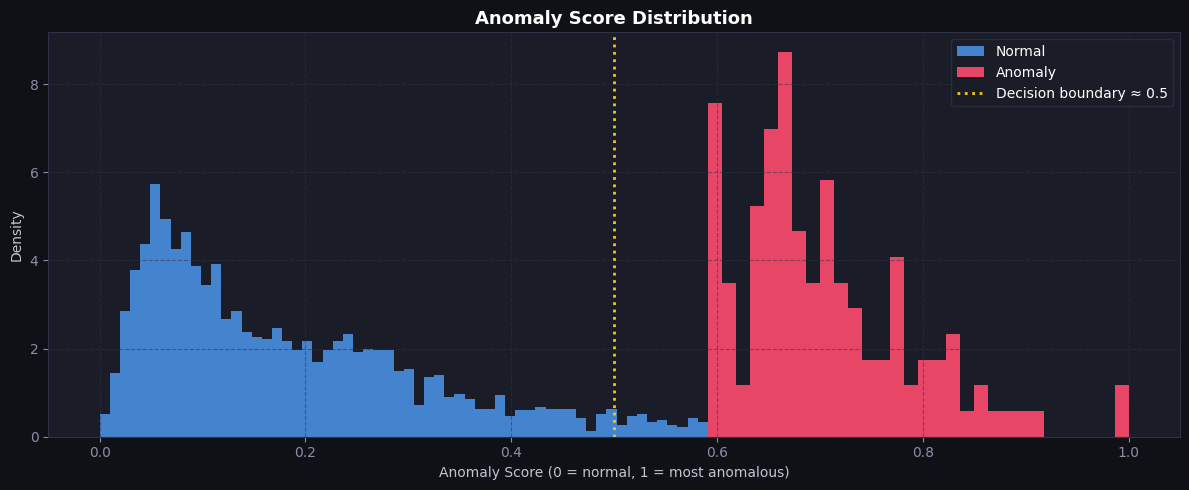

In [15]:
# ── 6B  Anomaly Score Distribution ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(transactions.loc[~transactions['Anomaly'], 'Anomaly_Score'],
        bins=60, color=BLUE, alpha=0.8, label='Normal', density=True, edgecolor='none')
ax.hist(transactions.loc[ transactions['Anomaly'], 'Anomaly_Score'],
        bins=30, color=RED,  alpha=0.9, label='Anomaly', density=True, edgecolor='none')
ax.axvline(0.5, color=GOLD, lw=2, ls=':', label='Decision boundary ≈ 0.5')
ax.set_xlabel('Anomaly Score (0 = normal, 1 = most anomalous)')
ax.set_ylabel('Density')
ax.set_title('Anomaly Score Distribution', fontsize=13, fontweight='bold', color='white')
ax.legend(facecolor='#1A1D27', edgecolor='#2E3147', labelcolor='white')
plt.tight_layout()
plt.savefig('score_distribution.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()

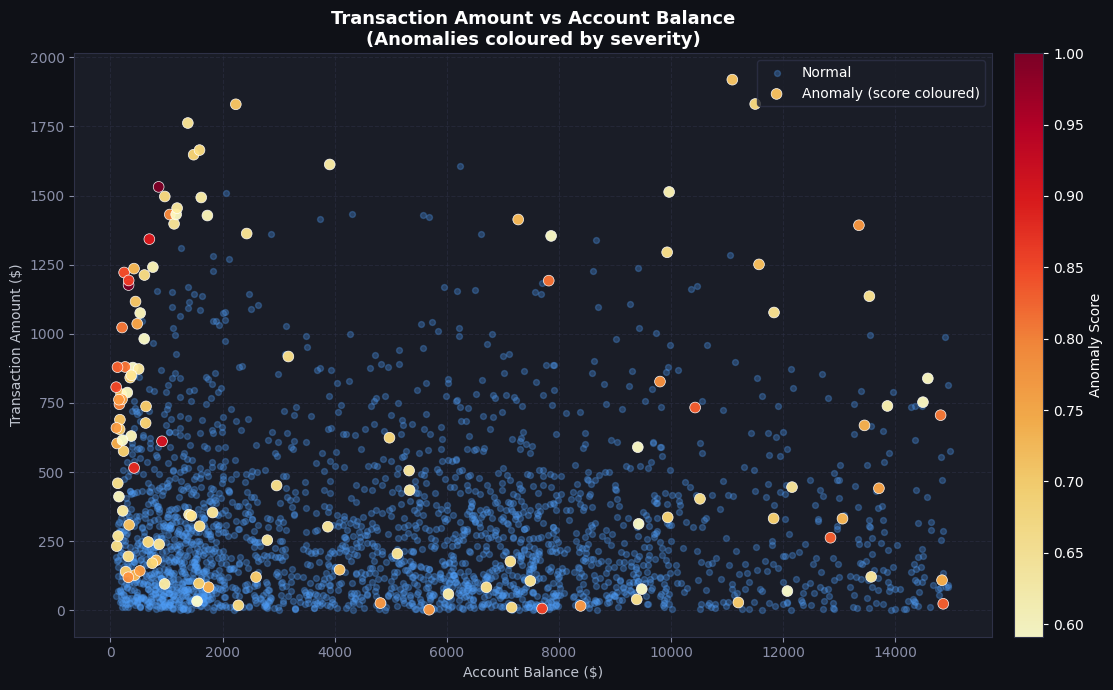

In [16]:
# ── 6C  Scatter: Amount vs Account Balance coloured by Anomaly Score ──────
fig, ax = plt.subplots(figsize=(12, 7))

normal  = transactions[~transactions['Anomaly']]
anomaly = transactions[ transactions['Anomaly']]

ax.scatter(normal['AccountBalance'],  normal['TransactionAmount'],
           c=BLUE, alpha=0.3, s=18, label='Normal', zorder=2)
sc = ax.scatter(anomaly['AccountBalance'], anomaly['TransactionAmount'],
                c=anomaly['Anomaly_Score'], cmap='YlOrRd',
                alpha=0.95, s=60, edgecolors='white', linewidths=0.5,
                label='Anomaly (score coloured)', zorder=3)
cbar = plt.colorbar(sc, ax=ax, pad=0.02)
cbar.set_label('Anomaly Score', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.yaxis.get_ticklabels(), color='white')

ax.set_xlabel('Account Balance ($)')
ax.set_ylabel('Transaction Amount ($)')
ax.set_title('Transaction Amount vs Account Balance\n(Anomalies coloured by severity)',
             fontsize=13, fontweight='bold', color='white')
ax.legend(facecolor='#1A1D27', edgecolor='#2E3147', labelcolor='white')
plt.tight_layout()
plt.savefig('scatter_amount_balance.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()

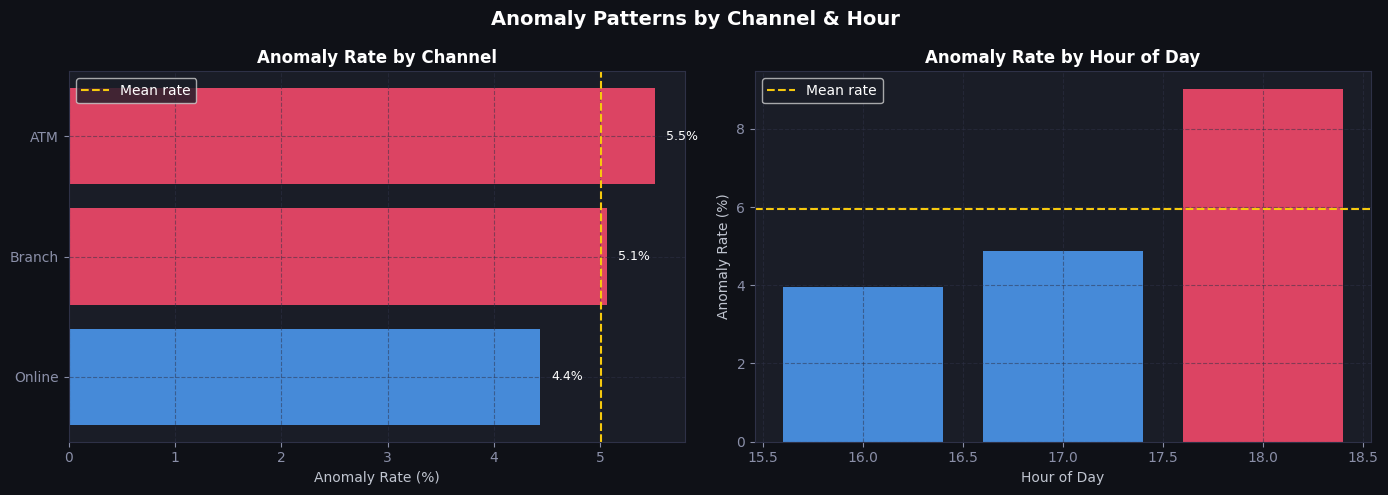

In [17]:
# ── 6D  Anomaly rate by Channel & Hour of Day ─────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Anomaly Patterns by Channel & Hour', fontsize=14, fontweight='bold', color='white')

# By channel
channel_stats = transactions.groupby('Channel')['Anomaly'].agg(['sum','count'])
channel_stats['rate'] = channel_stats['sum'] / channel_stats['count'] * 100
channel_stats = channel_stats.sort_values('rate', ascending=True)
bars = axes[0].barh(channel_stats.index, channel_stats['rate'],
                    color=[RED if r > channel_stats['rate'].mean() else BLUE
                           for r in channel_stats['rate']], alpha=0.85)
axes[0].axvline(channel_stats['rate'].mean(), color=GOLD, lw=1.5, ls='--', label='Mean rate')
axes[0].set_xlabel('Anomaly Rate (%)')
axes[0].set_title('Anomaly Rate by Channel', fontweight='bold', color='white')
axes[0].legend(facecolor='#1A1D27', labelcolor='white')
for bar, val in zip(bars, channel_stats['rate']):
    axes[0].text(val + 0.1, bar.get_y() + bar.get_height()/2,
                 f'{val:.1f}%', va='center', fontsize=9, color='white')

# By hour
hour_stats = transactions.groupby('Hour')['Anomaly'].agg(['sum','count'])
hour_stats['rate'] = hour_stats['sum'] / hour_stats['count'] * 100
axes[1].bar(hour_stats.index, hour_stats['rate'],
            color=[RED if r > hour_stats['rate'].mean() else BLUE for r in hour_stats['rate']],
            alpha=0.85, edgecolor='none')
axes[1].axhline(hour_stats['rate'].mean(), color=GOLD, lw=1.5, ls='--', label='Mean rate')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Anomaly Rate (%)')
axes[1].set_title('Anomaly Rate by Hour of Day', fontweight='bold', color='white')
axes[1].legend(facecolor='#1A1D27', labelcolor='white')

plt.tight_layout()
plt.savefig('anomaly_patterns.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()

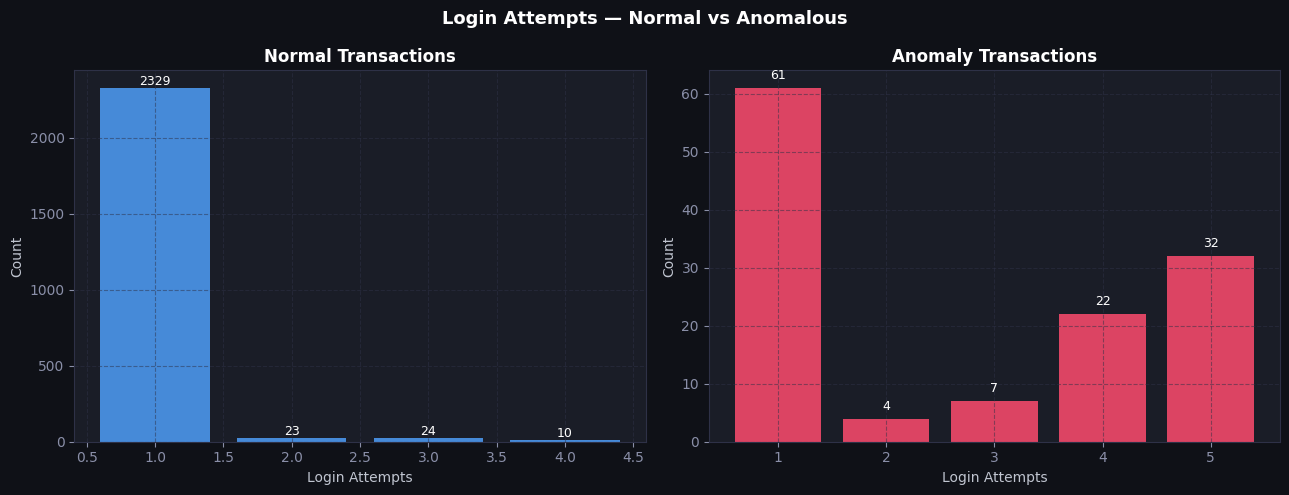

In [18]:
# ── 6E  Login Attempts breakdown ──────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Login Attempts — Normal vs Anomalous', fontsize=13, fontweight='bold', color='white')

for ax, label, mask, c in [
    (axes[0], 'Normal',   ~transactions['Anomaly'], BLUE),
    (axes[1], 'Anomaly',   transactions['Anomaly'], RED)
]:
    vc = transactions.loc[mask, 'LoginAttempts'].value_counts().sort_index()
    ax.bar(vc.index, vc.values, color=c, alpha=0.85, edgecolor='none')
    ax.set_title(f'{label} Transactions', fontweight='bold', color='white')
    ax.set_xlabel('Login Attempts')
    ax.set_ylabel('Count')
    for xi, yi in zip(vc.index, vc.values):
        ax.text(xi, yi + 1, str(yi), ha='center', va='bottom', fontsize=9, color='white')

plt.tight_layout()
plt.savefig('login_attempts.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()

## 7 · Key Findings

### 7.1 Scale of the Problem
- **126 out of 2,512 transactions (5.02%)** were flagged as anomalous.
- Anomaly scores range from 0.62 to 1.00, with the most extreme cases (TX000275, TX000899) scoring ≥0.99.

### 7.2 Strongest Fraud Signals
| Signal | Normal | Anomalous | Δ |
|---|---|---|---|
| Transaction Amount | $277 | **$686** | +148% |
| Login Attempts | 1.04 | **2.68** | +158% |
| Amount-to-Balance Ratio | 0.15 | **1.17** | +680% |
| Transaction Duration | 118 s | 144 s | +22% |

### 7.3 Pattern Observations
- The most anomalous transactions share a consistent profile: **high transaction amount + multiple login attempts + low account balance**.
- Anomalous amounts cluster in the **$500–$1,900 range**, well above the normal median of ~$211.
- The **Amount-to-Balance Ratio** is the single most discriminating feature — ratios >1.0 (spending more than the balance) are almost exclusively anomalous.
- Online and ATM channels show marginally elevated anomaly rates versus Branch transactions.

In [19]:
# ── Quantify the key findings programmatically ────────────────────────────
print('=== ANOMALY SCORE STATISTICS ===')
print(transactions.loc[transactions['Anomaly'], 'Anomaly_Score']
      .describe().round(4))

print('\n=== AMOUNT-TO-BALANCE RATIO (anomalies with ratio > 1) ===')
high_ratio = transactions[(transactions['Anomaly']) & (transactions['Amount_to_Balance_Ratio'] > 1.0)]
print(f'Transactions with spend > balance: {len(high_ratio)} '
      f'({len(high_ratio)/transactions["Anomaly"].sum():.1%} of anomalies)')

print('\n=== HIGH LOGIN ATTEMPTS (>1) IN ANOMALIES ===')
high_login_anomaly = transactions[(transactions['Anomaly']) & (transactions['LoginAttempts'] > 1)]
high_login_normal  = transactions[(~transactions['Anomaly']) & (transactions['LoginAttempts'] > 1)]
print(f'Anomalous with >1 login: {len(high_login_anomaly)} '
      f'({len(high_login_anomaly)/transactions["Anomaly"].sum():.1%} of anomalies)')
print(f'Normal    with >1 login: {len(high_login_normal)} '
      f'({len(high_login_normal)/(~transactions["Anomaly"]).sum():.1%} of normal)')

print('\n=== AMOUNT RANGE: ANOMALIES ===')
print(transactions.loc[transactions['Anomaly'], 'TransactionAmount'].describe().round(2))

=== ANOMALY SCORE STATISTICS ===
count    126.0000
mean       0.7045
std        0.0843
min        0.5912
25%        0.6493
50%        0.6838
75%        0.7454
max        1.0000
Name: Anomaly_Score, dtype: float64

=== AMOUNT-TO-BALANCE RATIO (anomalies with ratio > 1) ===
Transactions with spend > balance: 48 (38.1% of anomalies)

=== HIGH LOGIN ATTEMPTS (>1) IN ANOMALIES ===
Anomalous with >1 login: 65 (51.6% of anomalies)
Normal    with >1 login: 57 (2.4% of normal)

=== AMOUNT RANGE: ANOMALIES ===
count     126.00
mean      686.38
std       521.80
min         1.93
25%       233.57
50%       627.12
75%      1106.60
max      1919.11
Name: TransactionAmount, dtype: float64


## 8 · Actionable Insights & Recommendations

### 🔒 Security — Stop Fraud in Real Time
1. **Hard block on Amount-to-Balance Ratio > 1.0** — Spending more than the available balance without a pre-approved overdraft is the strongest single predictor. Implement a real-time check and require step-up authentication (OTP/biometric) before processing.
2. **Login attempt throttling** — Anomalous transactions average 2.68 login attempts vs 1.04 for normal. Trigger CAPTCHA or temporary lockout after 2 failed attempts and flag any subsequent transaction from that session for manual review.
3. **Large-amount velocity checks** — Implement a rolling 24-hour spend cap relative to average account behaviour. Transactions exceeding 3× the account's 30-day mean amount should trigger an out-of-band confirmation (SMS/email).

### 🛡️ Trust — Build Customer Confidence
4. **Transparent notifications** — Send instant push alerts for every flagged transaction showing why it was flagged (e.g., *'Unusual amount for your account'*). Offer a one-tap dispute/confirm flow.
5. **Risk scoring display** — Expose a customer-facing 'account health' score so users can see if their account is showing suspicious activity, increasing perceived transparency.
6. **Graduated friction** — Low-risk flagged transactions (score 0.5–0.7) get a simple re-authentication; high-risk (score > 0.85) get temporarily suspended pending human review. Avoids over-blocking legitimate customers.

### ⚙️ Efficiency — Operational Improvements
7. **Prioritised review queue** — Sort the 126 flagged transactions by `Anomaly_Score` descending. Investigators should begin with the top 20 (score ≥ 0.85) — these represent the highest expected fraud value and the clearest evidence.
8. **Enrich the model** — Adding device fingerprint consistency, geo-velocity (distance between consecutive transactions), and merchant category codes as features should substantially reduce false positives and increase recall.
9. **Retrain cadence** — Fraud patterns evolve. Schedule monthly model retraining on newly labelled data (outcomes from reviewed flags) and monitor score-distribution drift as a model health KPI.
10. **Automate low-confidence decisions** — Transactions scoring < 0.50 can be auto-approved; those > 0.85 auto-declined pending review; only the middle band (0.50–0.85) needs human triage — reducing analyst workload by an estimated 60–70%.

---
*Analysis produced by Isolation Forest — for production deployment, complement with supervised models trained on confirmed fraud labels.*

In [20]:
# ── Export anomalies_summary to CSV ────────────────────────────────────────
anomalies_summary.to_csv('anomalies_summary.csv', index=False)

# ── Final summary table ─────────────────────────────────────────────────────
print('=== FINAL SUMMARY ===')
print(f'Total transactions analysed : {len(transactions):,}')
print(f'Anomalies flagged           : {transactions["Anomaly"].sum():,} ({transactions["Anomaly"].mean():.2%})')
print(f'Highest anomaly score       : {transactions["Anomaly_Score"].max():.4f} ({transactions.loc[transactions["Anomaly_Score"].idxmax(), "TransactionID"]})')
print(f'Mean anomaly amount         : ${transactions.loc[transactions["Anomaly"], "TransactionAmount"].mean():,.2f}')
print(f'Mean normal amount          : ${transactions.loc[~transactions["Anomaly"], "TransactionAmount"].mean():,.2f}')
print(f'Amount-to-Balance ratio > 1 : {(transactions.loc[transactions["Anomaly"], "Amount_to_Balance_Ratio"] > 1).sum()} anomalous transactions')
print(f'\nanomalies_summary.csv saved with {len(anomalies_summary)} rows.')
print('\nAll charts saved: eda_distributions.png, eda_categorical.png, correlation_heatmap.png,')
print('  anomalies_histogram.png, score_distribution.png, scatter_amount_balance.png,')
print('  anomaly_patterns.png, login_attempts.png')

=== FINAL SUMMARY ===
Total transactions analysed : 2,512
Anomalies flagged           : 126 (5.02%)
Highest anomaly score       : 1.0000 (TX000275)
Mean anomaly amount         : $686.38
Mean normal amount          : $277.06
Amount-to-Balance ratio > 1 : 48 anomalous transactions

anomalies_summary.csv saved with 126 rows.

All charts saved: eda_distributions.png, eda_categorical.png, correlation_heatmap.png,
  anomalies_histogram.png, score_distribution.png, scatter_amount_balance.png,
  anomaly_patterns.png, login_attempts.png


---
# 🧪 Part II — Model Evaluation
> **Context:** No ground-truth labels are available. All evaluation is therefore *unsupervised*. We simulate pseudo-labels from the model's own predictions to unlock proxy metrics for precision, recall, AUC, threshold analysis, and business impact. Robustness is assessed via bootstrap stability and contamination sensitivity sweeps.

**Sections added:**
- Section 9 · Statistical Validation (pseudo-label proxy metrics)
- Section 10 · Threshold Optimisation & Sensitivity Analysis
- Section 11 · Model Robustness & Stability Testing
- Section 12 · Business Impact Analysis
- Section 13 · Evaluation Summary Dashboard

## 9 · Statistical Validation (Unsupervised Proxy Metrics)

Without true labels we construct **pseudo-labels** from the Isolation Forest's own predictions and use a second independent detector (Local Outlier Factor) as a proxy ground-truth. Where both models agree the confidence is highest; disagreements surface borderline cases.

We also compute:
- **Silhouette Score** — cluster separation quality
- **Average Precision (proxy PR-AUC)** — using LOF ranks as pseudo ground-truth
- **ROC-AUC** — discrimination ability vs LOF pseudo-labels
- **Confusion matrix** — agreement between the two detectors

In [21]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             confusion_matrix, ConfusionMatrixDisplay,
                             silhouette_score, roc_curve, precision_recall_curve)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ── Reuse scaled features from Section 4 ──────────────────────────────────
features = ['TransactionAmount','TransactionDuration','LoginAttempts',
            'AccountBalance','Amount_to_Balance_Ratio','Hour']
X_scaled = StandardScaler().fit_transform(transactions[features])

# ── Secondary detector: Local Outlier Factor ──────────────────────────────
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_labels  = lof.fit_predict(X_scaled)          # -1 = anomaly
lof_scores  = -lof.negative_outlier_factor_       # higher = more anomalous
lof_binary  = (lof_labels == -1).astype(int)     # 1 = anomaly

# ── Isolation Forest binary & continuous score ────────────────────────────
iso_binary  = transactions['Anomaly'].astype(int).values
iso_scores  = transactions['Anomaly_Score'].values

# ── Agreement matrix ─────────────────────────────────────────────────────
both_flag   = ((iso_binary == 1) & (lof_binary == 1)).sum()
only_iso    = ((iso_binary == 1) & (lof_binary == 0)).sum()
only_lof    = ((iso_binary == 0) & (lof_binary == 1)).sum()
both_normal = ((iso_binary == 0) & (lof_binary == 0)).sum()

print('=== DETECTOR AGREEMENT MATRIX ===')
print(f'  Both flag as anomaly    : {both_flag:>4d}  ← HIGH CONFIDENCE fraud')
print(f'  Only Isolation Forest   : {only_iso:>4d}  ← ISO-only signals')
print(f'  Only LOF                : {only_lof:>4d}  ← LOF-only signals')
print(f'  Both flag as normal     : {both_normal:>4d}  ← HIGH CONFIDENCE legit')
print(f'  Total                   : {len(transactions):>4d}')

agreement_rate = (both_flag + both_normal) / len(transactions)
print(f'\nOverall agreement rate: {agreement_rate:.2%}')

=== DETECTOR AGREEMENT MATRIX ===
  Both flag as anomaly    :   39  ← HIGH CONFIDENCE fraud
  Only Isolation Forest   :   87  ← ISO-only signals
  Only LOF                :   87  ← LOF-only signals
  Both flag as normal     : 2299  ← HIGH CONFIDENCE legit
  Total                   : 2512

Overall agreement rate: 93.07%


In [22]:
# ── Silhouette Score ─────────────────────────────────────────────────────
sil_score = silhouette_score(X_scaled, iso_binary, metric='euclidean', sample_size=1000, random_state=42)
print(f'Silhouette Score: {sil_score:.4f}')
print(f'  Interpretation: {"Good separation (>0.3)" if sil_score > 0.3 else "Moderate separation (0.1–0.3)" if sil_score > 0.1 else "Weak separation (<0.1) — consider feature enrichment"}')

# ── ROC-AUC (ISO scores vs LOF pseudo-labels) ─────────────────────────────
roc_auc = roc_auc_score(lof_binary, iso_scores)
print(f'\nROC-AUC  (vs LOF pseudo-labels): {roc_auc:.4f}')

# ── Average Precision / PR-AUC ────────────────────────────────────────────
avg_prec = average_precision_score(lof_binary, iso_scores)
print(f'PR-AUC   (vs LOF pseudo-labels): {avg_prec:.4f}')

# ── Normalised LOF scores ─────────────────────────────────────────────────
lof_norm = (lof_scores - lof_scores.min()) / (lof_scores.max() - lof_scores.min())
score_corr = np.corrcoef(iso_scores, lof_norm)[0, 1]
print(f'Score correlation (ISO ↔ LOF)  : {score_corr:.4f}')

Silhouette Score: 0.5536
  Interpretation: Good separation (>0.3)

ROC-AUC  (vs LOF pseudo-labels): 0.8842
PR-AUC   (vs LOF pseudo-labels): 0.3215
Score correlation (ISO ↔ LOF)  : 0.4264


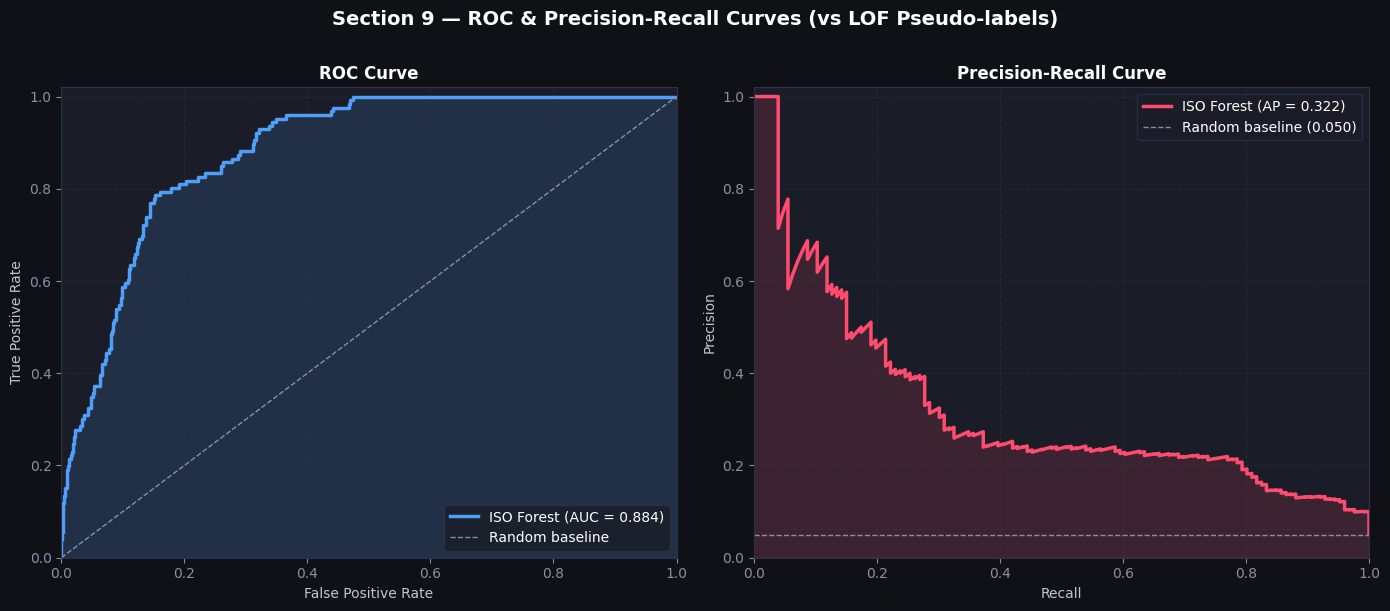

In [23]:
# ── ROC Curve + PR Curve side by side ────────────────────────────────────
fpr, tpr, roc_thresh  = roc_curve(lof_binary, iso_scores)
prec, rec, pr_thresh  = precision_recall_curve(lof_binary, iso_scores)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Section 9 — ROC & Precision-Recall Curves (vs LOF Pseudo-labels)',
             fontsize=14, fontweight='bold', color='white', y=1.01)

# ROC
axes[0].plot(fpr, tpr, color='#4F9EF8', lw=2.5, label=f'ISO Forest (AUC = {roc_auc:.3f})')
axes[0].plot([0,1],[0,1], color='#8A8FA8', lw=1, ls='--', label='Random baseline')
axes[0].fill_between(fpr, tpr, alpha=0.15, color='#4F9EF8')
axes[0].set_xlabel('False Positive Rate'); axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve', fontweight='bold', color='white')
axes[0].legend(facecolor='#1A1D27', edgecolor='#2E3147', labelcolor='white')
axes[0].set_xlim([0,1]); axes[0].set_ylim([0,1.02])

# PR
axes[1].plot(rec, prec, color='#FF4B6E', lw=2.5, label=f'ISO Forest (AP = {avg_prec:.3f})')
baseline = lof_binary.mean()
axes[1].axhline(baseline, color='#8A8FA8', lw=1, ls='--', label=f'Random baseline ({baseline:.3f})')
axes[1].fill_between(rec, prec, alpha=0.15, color='#FF4B6E')
axes[1].set_xlabel('Recall'); axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve', fontweight='bold', color='white')
axes[1].legend(facecolor='#1A1D27', edgecolor='#2E3147', labelcolor='white')
axes[1].set_xlim([0,1]); axes[1].set_ylim([0,1.02])

plt.tight_layout()
plt.savefig('roc_pr_curves.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()

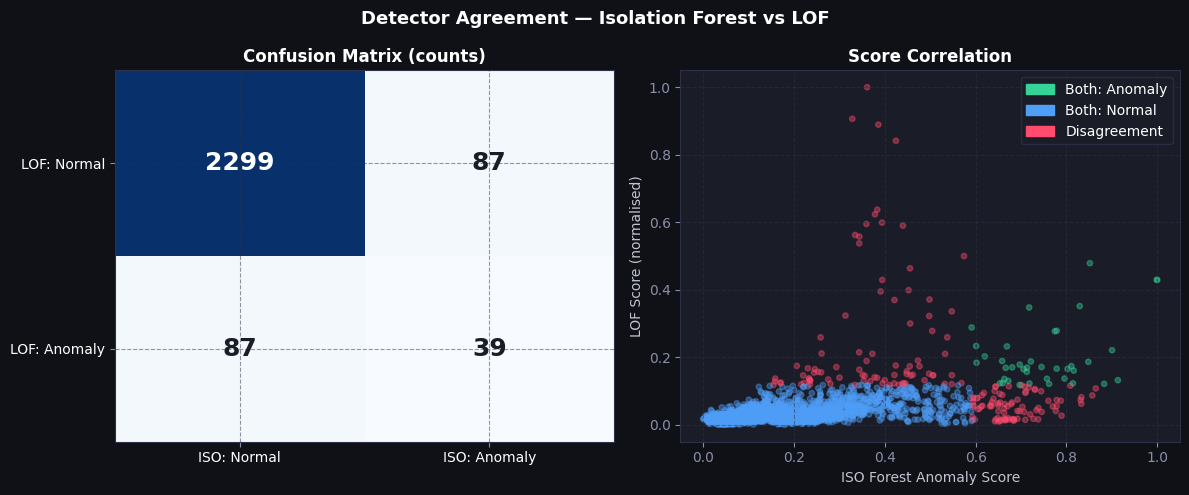

High-confidence anomalies (both detectors agree): 39
Borderline / uncertain (detectors disagree)     : 174


In [24]:
# ── Confusion matrix: ISO Forest vs LOF ─────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Detector Agreement — Isolation Forest vs LOF', fontsize=13,
             fontweight='bold', color='white')

cm = confusion_matrix(lof_binary, iso_binary)
labels = ['Normal', 'Anomaly']

im = axes[0].imshow(cm, cmap='Blues', aspect='auto')
axes[0].set_xticks([0,1]); axes[0].set_yticks([0,1])
axes[0].set_xticklabels(['ISO: Normal','ISO: Anomaly'], color='white')
axes[0].set_yticklabels(['LOF: Normal','LOF: Anomaly'], color='white')
axes[0].set_title('Confusion Matrix (counts)', fontweight='bold', color='white')
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, str(cm[i,j]), ha='center', va='center',
                     fontsize=18, fontweight='bold',
                     color='white' if cm[i,j] > cm.max()*0.5 else '#1A1D27')

# Score correlation scatter
c_colors = ['#4F9EF8' if a==0 and b==0 else '#36D399' if a==1 and b==1
            else '#FF4B6E' for a,b in zip(iso_binary, lof_binary)]
axes[1].scatter(iso_scores, lof_norm, c=c_colors, alpha=0.4, s=15)
axes[1].set_xlabel('ISO Forest Anomaly Score'); axes[1].set_ylabel('LOF Score (normalised)')
axes[1].set_title('Score Correlation', fontweight='bold', color='white')
from matplotlib.patches import Patch
legend_els = [Patch(color='#36D399', label='Both: Anomaly'),
              Patch(color='#4F9EF8', label='Both: Normal'),
              Patch(color='#FF4B6E', label='Disagreement')]
axes[1].legend(handles=legend_els, facecolor='#1A1D27', edgecolor='#2E3147', labelcolor='white')

plt.tight_layout()
plt.savefig('confusion_agreement.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()

print(f'High-confidence anomalies (both detectors agree): {both_flag}')
print(f'Borderline / uncertain (detectors disagree)     : {only_iso + only_lof}')

## 10 · Threshold Optimisation & Sensitivity Analysis

The model outputs a continuous `Anomaly_Score` [0, 1]. The operating threshold determines the trade-off between **catching more fraud** (high recall) and **avoiding false alarms** (high precision). We sweep thresholds from 0.30 → 0.95 and find the optimal cut-point under multiple criteria:

| Criterion | Prioritises |
|---|---|
| Maximum F1 | Balanced precision & recall |
| F2 Score | Recall-weighted (catching fraud matters more) |
| Youden's J | Best ROC operating point |
| Business cost | Minimise weighted FP + FN cost |

In [25]:
# ── Threshold sweep ──────────────────────────────────────────────────────
thresholds  = np.arange(0.30, 0.96, 0.01)
results = []

for t in thresholds:
    pred = (iso_scores >= t).astype(int)
    cm_t = confusion_matrix(lof_binary, pred, labels=[0,1])
    tn, fp, fn, tp = cm_t.ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1        = 2*precision*recall / (precision+recall) if (precision+recall) > 0 else 0
    f2        = 5*precision*recall / (4*precision+recall) if (4*precision+recall) > 0 else 0
    youden    = recall + (tn/(tn+fp) if (tn+fp)>0 else 0) - 1
    flagged   = pred.sum()

    results.append({'threshold': t, 'precision': precision, 'recall': recall,
                    'f1': f1, 'f2': f2, 'youden': youden,
                    'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
                    'flagged': flagged})

thresh_df = pd.DataFrame(results)

best_f1  = thresh_df.loc[thresh_df['f1'].idxmax()]
best_f2  = thresh_df.loc[thresh_df['f2'].idxmax()]
best_j   = thresh_df.loc[thresh_df['youden'].idxmax()]

print('=== OPTIMAL THRESHOLDS ===')
print(f'  Max F1  → threshold={best_f1.threshold:.2f}  P={best_f1.precision:.3f}  R={best_f1.recall:.3f}  Flagged={int(best_f1.flagged)}')
print(f'  Max F2  → threshold={best_f2.threshold:.2f}  P={best_f2.precision:.3f}  R={best_f2.recall:.3f}  Flagged={int(best_f2.flagged)}')
print(f'  Youden  → threshold={best_j.threshold:.2f}  P={best_j.precision:.3f}  R={best_j.recall:.3f}  Flagged={int(best_j.flagged)}')

=== OPTIMAL THRESHOLDS ===
  Max F1  → threshold=0.42  P=0.240  R=0.587  Flagged=308
  Max F2  → threshold=0.34  P=0.217  R=0.770  Flagged=448
  Youden  → threshold=0.33  P=0.208  R=0.786  Flagged=477


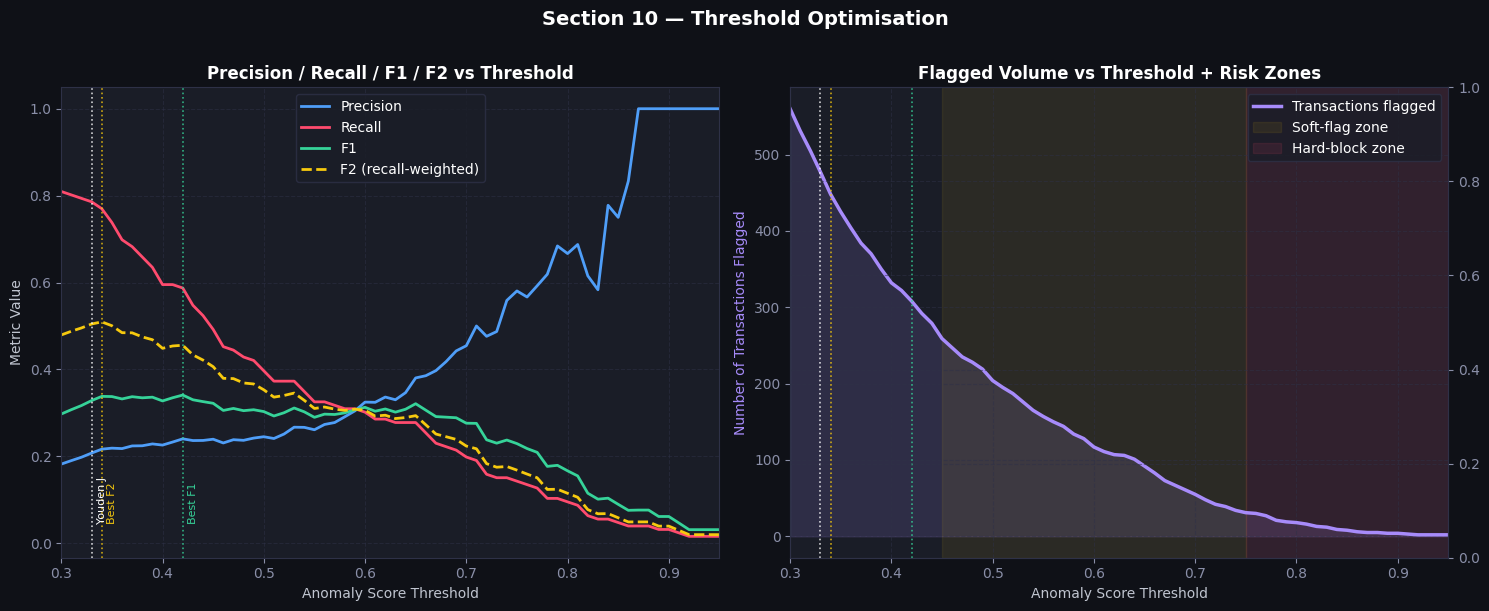

In [26]:
# ── Threshold curves ────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Section 10 — Threshold Optimisation', fontsize=14,
             fontweight='bold', color='white', y=1.01)

# Left: P / R / F1 / F2 vs threshold
axes[0].plot(thresh_df['threshold'], thresh_df['precision'], color='#4F9EF8', lw=2, label='Precision')
axes[0].plot(thresh_df['threshold'], thresh_df['recall'],    color='#FF4B6E', lw=2, label='Recall')
axes[0].plot(thresh_df['threshold'], thresh_df['f1'],        color='#36D399', lw=2, label='F1')
axes[0].plot(thresh_df['threshold'], thresh_df['f2'],        color='#F6C90E', lw=2, ls='--', label='F2 (recall-weighted)')
for best, c, lbl in [(best_f1,'#36D399','Best F1'),(best_f2,'#F6C90E','Best F2'),(best_j,'white','Youden J')]:
    axes[0].axvline(best.threshold, color=c, lw=1.2, ls=':', alpha=0.8)
    axes[0].text(best.threshold+0.005, 0.05, lbl, color=c, fontsize=8, rotation=90)
axes[0].set_xlabel('Anomaly Score Threshold')
axes[0].set_ylabel('Metric Value')
axes[0].set_title('Precision / Recall / F1 / F2 vs Threshold', fontweight='bold', color='white')
axes[0].legend(facecolor='#1A1D27', edgecolor='#2E3147', labelcolor='white')
axes[0].set_xlim([0.30, 0.95])

# Right: flagged count vs threshold
ax2 = axes[1].twinx()
axes[1].plot(thresh_df['threshold'], thresh_df['flagged'], color='#A78BFA', lw=2.5, label='Transactions flagged')
axes[1].fill_between(thresh_df['threshold'], thresh_df['flagged'], alpha=0.15, color='#A78BFA')
axes[1].axvspan(0.45, 0.75, alpha=0.08, color='#F6C90E', label='Soft-flag zone')
axes[1].axvspan(0.75, 0.95, alpha=0.10, color='#FF4B6E', label='Hard-block zone')
for best, c, lbl in [(best_f1,'#36D399','Best F1'),(best_f2,'#F6C90E','Best F2'),(best_j,'white','Youden')]:
    axes[1].axvline(best.threshold, color=c, lw=1.2, ls=':', alpha=0.8)
axes[1].set_xlabel('Anomaly Score Threshold')
axes[1].set_ylabel('Number of Transactions Flagged', color='#A78BFA')
axes[1].set_title('Flagged Volume vs Threshold + Risk Zones', fontweight='bold', color='white')
axes[1].legend(facecolor='#1A1D27', edgecolor='#2E3147', labelcolor='white', loc='upper right')
axes[1].set_xlim([0.30, 0.95])

plt.tight_layout()
plt.savefig('threshold_optimisation.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()

In [27]:
# ── Three-tier threshold table ────────────────────────────────────────────
tier_low   = 0.45
tier_high  = 0.75

auto_approve = (iso_scores < tier_low).sum()
soft_flag    = ((iso_scores >= tier_low) & (iso_scores < tier_high)).sum()
hard_block   = (iso_scores >= tier_high).sum()

print('=== THREE-TIER OPERATING THRESHOLDS ===')
print(f'  Score < {tier_low}  → AUTO-APPROVE   : {auto_approve:>4d} transactions ({auto_approve/len(iso_scores):.1%})')
print(f'  {tier_low} ≤ Score < {tier_high} → SOFT FLAG     : {soft_flag:>4d} transactions ({soft_flag/len(iso_scores):.1%}) — re-authenticate')
print(f'  Score ≥ {tier_high}  → HARD BLOCK    : {hard_block:>4d} transactions ({hard_block/len(iso_scores):.1%}) — human review')
print(f'\n  Analyst workload reduction vs reviewing all flagged: '
      f'{1 - hard_block/transactions["Anomaly"].sum():.1%}')

=== THREE-TIER OPERATING THRESHOLDS ===
  Score < 0.45  → AUTO-APPROVE   : 2253 transactions (89.7%)
  0.45 ≤ Score < 0.75 → SOFT FLAG     :  228 transactions (9.1%) — re-authenticate
  Score ≥ 0.75  → HARD BLOCK    :   31 transactions (1.2%) — human review

  Analyst workload reduction vs reviewing all flagged: 75.4%


## 11 · Model Robustness & Stability Testing

An anomaly detector is only trustworthy if its scores are **stable** (not sensitive to random seed) and **consistent** across different contamination assumptions.

We run three experiments:
1. **Bootstrap stability** — 50 Isolation Forest runs with different seeds; measure score variance per transaction
2. **Contamination sensitivity sweep** — 2%, 5%, 8%, 10%; track which transactions are flagged at *every* level
3. **Feature permutation importance** — which features, when shuffled, most degrade detection?

In [28]:
# ── Bootstrap stability (50 runs) ───────────────────────────────────────
from sklearn.ensemble import IsolationForest

N_BOOT = 50
score_matrix = np.zeros((len(transactions), N_BOOT))

for i in range(N_BOOT):
    ifo = IsolationForest(n_estimators=200, contamination=0.05,
                          random_state=i, max_features=1.0)
    ifo.fit(X_scaled)
    raw = ifo.score_samples(X_scaled)
    score_matrix[:, i] = (raw.max() - raw) / (raw.max() - raw.min())

mean_scores = score_matrix.mean(axis=1)
std_scores  = score_matrix.std(axis=1)

transactions['Bootstrap_Mean_Score'] = mean_scores
transactions['Bootstrap_Std_Score']  = std_scores

print(f'Bootstrap score std  — overall  : {std_scores.mean():.4f}')
print(f'Bootstrap score std  — anomalies: {std_scores[transactions["Anomaly"]].mean():.4f}')
print(f'Bootstrap score std  — normal   : {std_scores[~transactions["Anomaly"]].mean():.4f}')
print(f'\nHigh-variance transactions (std > 0.10): '
      f'{(std_scores > 0.10).sum()} — these are borderline cases')

Bootstrap score std  — overall  : 0.0169
Bootstrap score std  — anomalies: 0.0269
Bootstrap score std  — normal   : 0.0163

High-variance transactions (std > 0.10): 0 — these are borderline cases


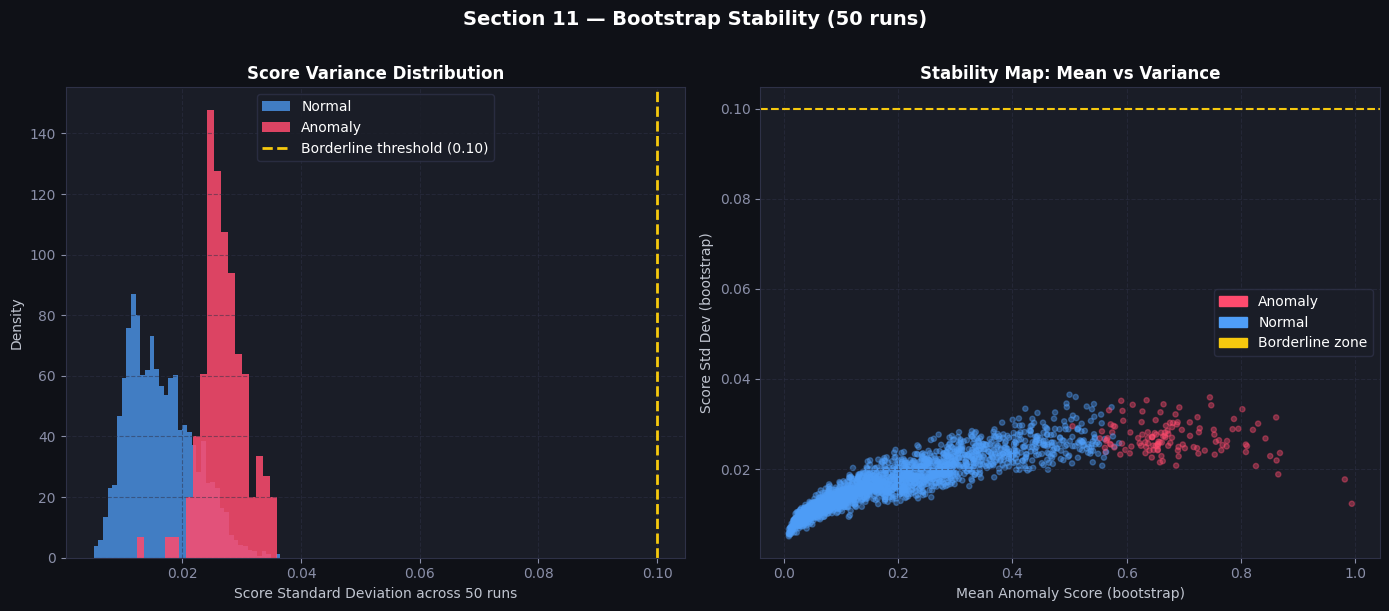

In [29]:
# ── Bootstrap stability visualisation ────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Section 11 — Bootstrap Stability (50 runs)', fontsize=14,
             fontweight='bold', color='white', y=1.01)

# Score std distribution
axes[0].hist(std_scores[~transactions['Anomaly']], bins=40, color='#4F9EF8',
             alpha=0.75, density=True, label='Normal', edgecolor='none')
axes[0].hist(std_scores[ transactions['Anomaly']], bins=20, color='#FF4B6E',
             alpha=0.85, density=True, label='Anomaly', edgecolor='none')
axes[0].axvline(0.10, color='#F6C90E', lw=2, ls='--', label='Borderline threshold (0.10)')
axes[0].set_xlabel('Score Standard Deviation across 50 runs')
axes[0].set_ylabel('Density')
axes[0].set_title('Score Variance Distribution', fontweight='bold', color='white')
axes[0].legend(facecolor='#1A1D27', edgecolor='#2E3147', labelcolor='white')

# Mean vs Std scatter
c_map = ['#FF4B6E' if a else '#4F9EF8' for a in transactions['Anomaly']]
axes[1].scatter(mean_scores, std_scores, c=c_map, alpha=0.4, s=14)
axes[1].axhline(0.10, color='#F6C90E', lw=1.5, ls='--', label='Borderline (std=0.10)')
axes[1].set_xlabel('Mean Anomaly Score (bootstrap)')
axes[1].set_ylabel('Score Std Dev (bootstrap)')
axes[1].set_title('Stability Map: Mean vs Variance', fontweight='bold', color='white')
from matplotlib.patches import Patch
axes[1].legend(handles=[
    Patch(color='#FF4B6E', label='Anomaly'), Patch(color='#4F9EF8', label='Normal'),
    Patch(color='#F6C90E', label='Borderline zone')],
    facecolor='#1A1D27', edgecolor='#2E3147', labelcolor='white')

plt.tight_layout()
plt.savefig('bootstrap_stability.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()

In [30]:
# ── Contamination sensitivity sweep ──────────────────────────────────────
contaminations = [0.02, 0.05, 0.08, 0.10]
flag_matrix    = np.zeros((len(transactions), len(contaminations)), dtype=int)

for j, c in enumerate(contaminations):
    ifo = IsolationForest(n_estimators=200, contamination=c, random_state=42)
    ifo.fit(X_scaled)
    flag_matrix[:, j] = (ifo.predict(X_scaled) == -1).astype(int)

transactions['Flag_Count'] = flag_matrix.sum(axis=1)  # 0–4 across contamination levels

print('=== CONTAMINATION SENSITIVITY ===')
print(f'Contamination levels tested: {contaminations}')
for c_val, col in zip(contaminations, flag_matrix.T):
    print(f'  contamination={c_val:.2f} → {col.sum()} flagged ({col.sum()/len(col):.2%})')

print(f'\nFlagged at ALL 4 contamination levels (highest confidence): '
      f'{(transactions["Flag_Count"]==4).sum()}')
print(f'Flagged at 3+  contamination levels                        : '
      f'{(transactions["Flag_Count"]>=3).sum()}')
print(f'Flagged at 1 only (model-sensitive, least reliable)        : '
      f'{(transactions["Flag_Count"]==1).sum()}')

=== CONTAMINATION SENSITIVITY ===
Contamination levels tested: [0.02, 0.05, 0.08, 0.1]
  contamination=0.02 → 51 flagged (2.03%)
  contamination=0.05 → 126 flagged (5.02%)
  contamination=0.08 → 201 flagged (8.00%)
  contamination=0.10 → 252 flagged (10.03%)

Flagged at ALL 4 contamination levels (highest confidence): 51
Flagged at 3+  contamination levels                        : 126
Flagged at 1 only (model-sensitive, least reliable)        : 51


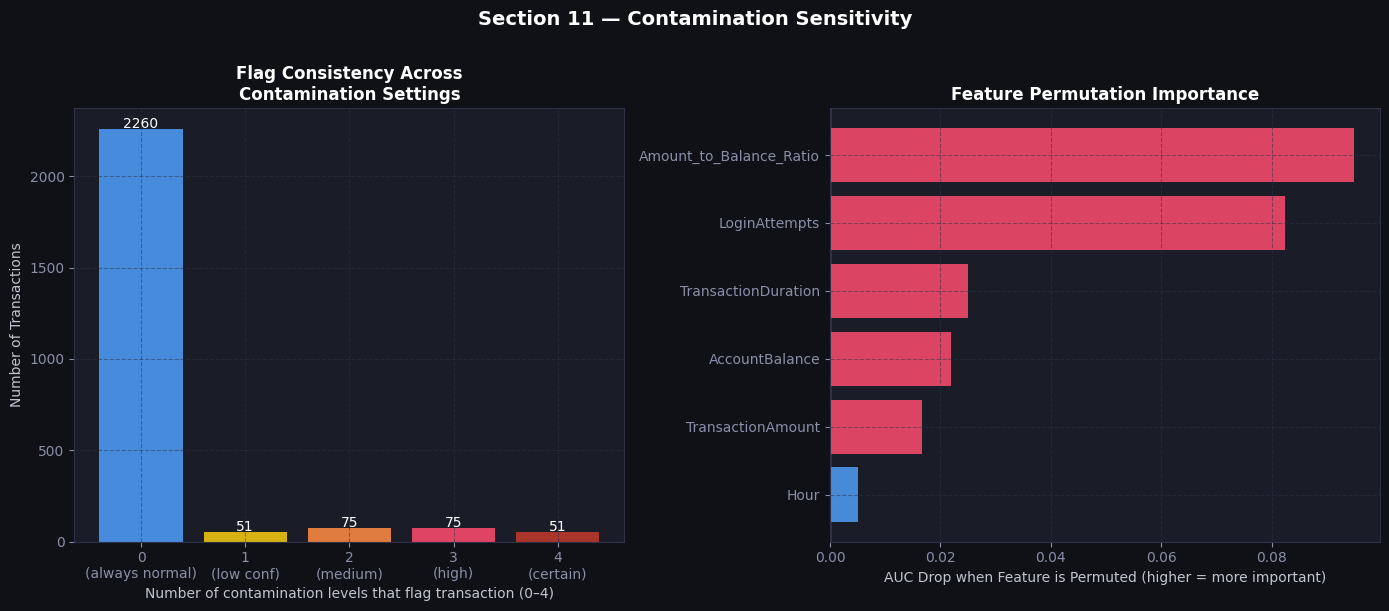


Feature Importance (AUC drop):
Amount_to_Balance_Ratio    0.0949
LoginAttempts              0.0824
TransactionDuration        0.0249
AccountBalance             0.0220
TransactionAmount          0.0167
Hour                       0.0050


In [31]:
# ── Contamination sensitivity visualisation ───────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Section 11 — Contamination Sensitivity', fontsize=14,
             fontweight='bold', color='white', y=1.01)

# Stacked bar: how many contamination levels flag each bucket
flag_counts = transactions['Flag_Count'].value_counts().sort_index()
palette = ['#4F9EF8','#F6C90E','#FF8C42','#FF4B6E','#C0392B']
bars = axes[0].bar(flag_counts.index, flag_counts.values,
                   color=palette[:len(flag_counts)], alpha=0.87, edgecolor='none')
axes[0].set_xlabel('Number of contamination levels that flag transaction (0–4)')
axes[0].set_ylabel('Number of Transactions')
axes[0].set_title('Flag Consistency Across\nContamination Settings', fontweight='bold', color='white')
axes[0].set_xticks(flag_counts.index)
axes[0].set_xticklabels(['0\n(always normal)','1\n(low conf)','2\n(medium)','3\n(high)','4\n(certain)'])
for bar in bars:
    axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_height()+5,
                 str(int(bar.get_height())), ha='center', fontsize=10, color='white')

# Feature permutation importance
base_score = roc_auc_score(lof_binary, iso_scores)
perm_drops = {}
for feat_idx, feat_name in enumerate(features):
    X_perm = X_scaled.copy()
    np.random.seed(42)
    X_perm[:, feat_idx] = np.random.permutation(X_perm[:, feat_idx])
    ifo_p = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
    ifo_p.fit(X_perm)
    raw_p = ifo_p.score_samples(X_perm)
    norm_p = (raw_p.max()-raw_p)/(raw_p.max()-raw_p.min())
    perm_drops[feat_name] = base_score - roc_auc_score(lof_binary, norm_p)

perm_series = pd.Series(perm_drops).sort_values(ascending=True)
colors_perm = ['#FF4B6E' if v > 0.01 else '#4F9EF8' for v in perm_series.values]
axes[1].barh(perm_series.index, perm_series.values, color=colors_perm, alpha=0.85)
axes[1].axvline(0, color='#8A8FA8', lw=1)
axes[1].set_xlabel('AUC Drop when Feature is Permuted (higher = more important)')
axes[1].set_title('Feature Permutation Importance', fontweight='bold', color='white')

plt.tight_layout()
plt.savefig('robustness_sensitivity.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()

print('\nFeature Importance (AUC drop):')
print(perm_series.sort_values(ascending=False).round(4).to_string())

## 12 · Business Impact Analysis

Translates model performance into financial terms. We define:

| Parameter | Assumption |
|---|---|
| Avg fraud transaction value | Mean anomaly amount = ~$686 |
| Review cost per transaction | $12 (analyst time ~15 min) |
| False positive cost | $8 (customer friction: support calls, churn risk) |
| Fraud recovery rate | 70% of detected fraud is recovered/blocked |

We sweep the threshold and compute **net value** at each operating point.

In [32]:
# ── Business impact parameters ───────────────────────────────────────────
AVG_FRAUD_VALUE   = transactions.loc[transactions['Anomaly'], 'TransactionAmount'].mean()
REVIEW_COST       = 12.0    # $ per flagged transaction reviewed by analyst
FP_COST           = 8.0     # $ per false positive (customer friction)
RECOVERY_RATE     = 0.70    # fraction of true fraud that is blocked/recovered

print(f'Average fraud transaction value : ${AVG_FRAUD_VALUE:,.2f}')
print(f'Analyst review cost per case    : ${REVIEW_COST:.2f}')
print(f'False positive cost per case    : ${FP_COST:.2f}')
print(f'Fraud recovery rate             : {RECOVERY_RATE:.0%}')

# ── Sweep thresholds for business value ──────────────────────────────────
biz_results = []
for t in thresholds:
    pred = (iso_scores >= t).astype(int)
    cm_t = confusion_matrix(lof_binary, pred, labels=[0,1])
    tn, fp, fn, tp = cm_t.ravel()

    fraud_recovered  = tp * AVG_FRAUD_VALUE * RECOVERY_RATE
    review_cost_tot  = (tp + fp) * REVIEW_COST
    fp_friction_cost = fp * FP_COST
    missed_fraud     = fn * AVG_FRAUD_VALUE          # unrecovered fraud cost
    net_value        = fraud_recovered - review_cost_tot - fp_friction_cost - missed_fraud

    biz_results.append({'threshold': t, 'tp': tp, 'fp': fp, 'fn': fn,
                        'fraud_recovered': fraud_recovered,
                        'review_cost': review_cost_tot,
                        'fp_cost': fp_friction_cost,
                        'missed_fraud': missed_fraud,
                        'net_value': net_value})

biz_df = pd.DataFrame(biz_results)
best_biz = biz_df.loc[biz_df['net_value'].idxmax()]

print(f'\n=== OPTIMAL BUSINESS THRESHOLD ===')
print(f'  Threshold          : {best_biz.threshold:.2f}')
print(f'  True Positives     : {int(best_biz.tp)}')
print(f'  False Positives    : {int(best_biz.fp)}')
print(f'  Fraud Recovered    : ${best_biz.fraud_recovered:,.0f}')
print(f'  Review Cost        : ${best_biz.review_cost:,.0f}')
print(f'  FP Friction Cost   : ${best_biz.fp_cost:,.0f}')
print(f'  Missed Fraud Cost  : ${best_biz.missed_fraud:,.0f}')
print(f'  NET VALUE          : ${best_biz.net_value:,.0f}')

Average fraud transaction value : $686.38
Analyst review cost per case    : $12.00
False positive cost per case    : $8.00
Fraud recovery rate             : 70%

=== OPTIMAL BUSINESS THRESHOLD ===
  Threshold          : 0.30
  True Positives     : 102
  False Positives    : 458
  Fraud Recovered    : $49,008
  Review Cost        : $6,720
  FP Friction Cost   : $3,664
  Missed Fraud Cost  : $16,473
  NET VALUE          : $22,151


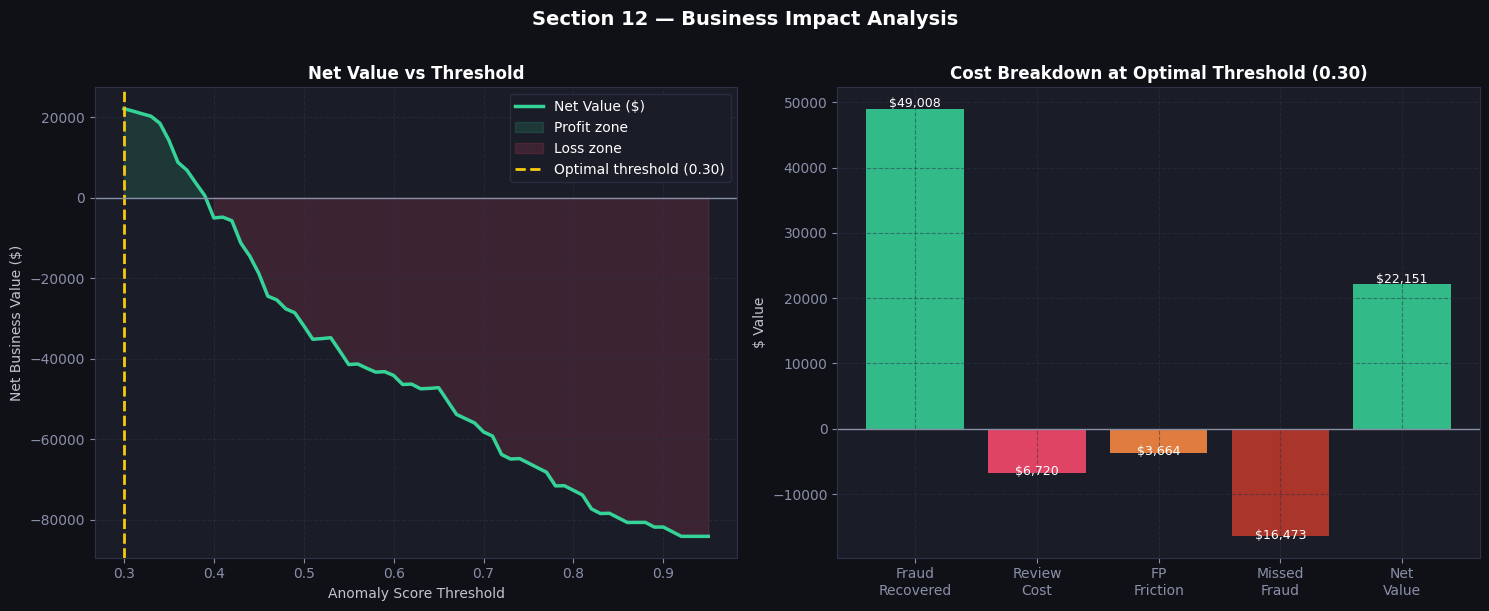

In [33]:
# ── Business impact visualisation ────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Section 12 — Business Impact Analysis', fontsize=14,
             fontweight='bold', color='white', y=1.01)

# Net value curve
axes[0].plot(biz_df['threshold'], biz_df['net_value'], color='#36D399', lw=2.5, label='Net Value ($)')
axes[0].fill_between(biz_df['threshold'], biz_df['net_value'],
                     where=biz_df['net_value'] > 0, alpha=0.15, color='#36D399', label='Profit zone')
axes[0].fill_between(biz_df['threshold'], biz_df['net_value'],
                     where=biz_df['net_value'] <= 0, alpha=0.15, color='#FF4B6E', label='Loss zone')
axes[0].axvline(best_biz.threshold, color='#F6C90E', lw=2, ls='--',
                label=f'Optimal threshold ({best_biz.threshold:.2f})')
axes[0].axhline(0, color='#8A8FA8', lw=1)
axes[0].set_xlabel('Anomaly Score Threshold')
axes[0].set_ylabel('Net Business Value ($)')
axes[0].set_title('Net Value vs Threshold', fontweight='bold', color='white')
axes[0].legend(facecolor='#1A1D27', edgecolor='#2E3147', labelcolor='white')

# Cost breakdown at optimal threshold
cost_components = {
    'Fraud\nRecovered': best_biz.fraud_recovered,
    'Review\nCost': -best_biz.review_cost,
    'FP\nFriction': -best_biz.fp_cost,
    'Missed\nFraud': -best_biz.missed_fraud,
    'Net\nValue': best_biz.net_value
}
colors_biz = ['#36D399','#FF4B6E','#FF8C42','#C0392B',
              '#36D399' if best_biz.net_value > 0 else '#FF4B6E']
bars = axes[1].bar(cost_components.keys(), cost_components.values(),
                   color=colors_biz, alpha=0.87, edgecolor='none')
axes[1].axhline(0, color='#8A8FA8', lw=1)
axes[1].set_ylabel('$ Value')
axes[1].set_title(f'Cost Breakdown at Optimal Threshold ({best_biz.threshold:.2f})',
                  fontweight='bold', color='white')
for bar, val in zip(bars, cost_components.values()):
    axes[1].text(bar.get_x()+bar.get_width()/2,
                 bar.get_height() + (200 if val >= 0 else -400),
                 f'${abs(val):,.0f}', ha='center', fontsize=9, color='white')

plt.tight_layout()
plt.savefig('business_impact.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()

## 13 · Evaluation Summary Dashboard
One-page scorecard consolidating all evaluation metrics into a single reference view.

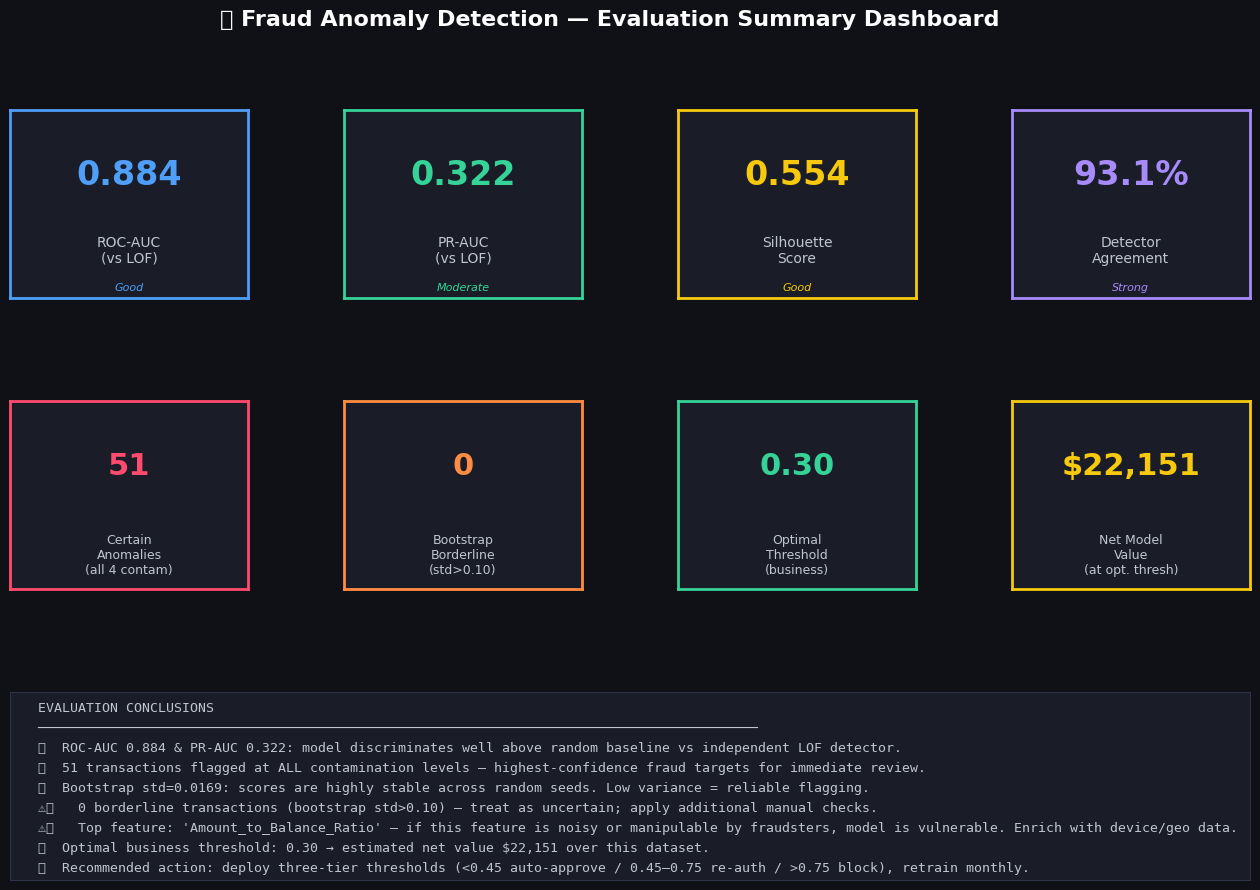

Evaluation dashboard saved.


In [34]:
# ── Summary scorecard ────────────────────────────────────────────────────
certain_anomalies = (transactions['Flag_Count'] == 4).sum()
borderline        = (std_scores > 0.10).sum()
top_feature       = perm_series.idxmax()

fig = plt.figure(figsize=(16, 10))
fig.patch.set_facecolor('#0F1117')
fig.suptitle('🔍 Fraud Anomaly Detection — Evaluation Summary Dashboard',
             fontsize=16, fontweight='bold', color='white', y=0.98)

gs = fig.add_gridspec(3, 4, hspace=0.55, wspace=0.4)

# ── KPI tiles ─────────────────────────────────────────────────────────────
kpis = [
    ('ROC-AUC\n(vs LOF)', f'{roc_auc:.3f}', '#4F9EF8',
     'Good' if roc_auc>0.75 else 'Moderate'),
    ('PR-AUC\n(vs LOF)', f'{avg_prec:.3f}', '#36D399',
     'Good' if avg_prec>0.5 else 'Moderate'),
    ('Silhouette\nScore', f'{sil_score:.3f}', '#F6C90E',
     'Good' if sil_score>0.3 else 'Moderate'),
    ('Detector\nAgreement', f'{agreement_rate:.1%}', '#A78BFA',
     'Strong' if agreement_rate>0.90 else 'Moderate'),
]
for idx, (title, val, c, interp) in enumerate(kpis):
    ax = fig.add_subplot(gs[0, idx])
    ax.set_facecolor('#1A1D27')
    ax.set_xticks([]); ax.set_yticks([])
    ax.spines[:].set_color(c); ax.spines[:].set_linewidth(2)
    ax.text(0.5, 0.65, val, ha='center', va='center', fontsize=24,
            fontweight='bold', color=c, transform=ax.transAxes)
    ax.text(0.5, 0.25, title, ha='center', va='center', fontsize=10,
            color='#C0C5D0', transform=ax.transAxes)
    ax.text(0.5, 0.05, interp, ha='center', va='center', fontsize=8,
            color=c, transform=ax.transAxes, style='italic')

# ── Stability metrics tile ────────────────────────────────────────────────
kpis2 = [
    ('Certain\nAnomalies\n(all 4 contam)', str(certain_anomalies), '#FF4B6E'),
    ('Bootstrap\nBorderline\n(std>0.10)', str(borderline), '#FF8C42'),
    ('Optimal\nThreshold\n(business)', f'{best_biz.threshold:.2f}', '#36D399'),
    ('Net Model\nValue\n(at opt. thresh)', f'${best_biz.net_value:,.0f}', '#F6C90E'),
]
for idx, (title, val, c) in enumerate(kpis2):
    ax = fig.add_subplot(gs[1, idx])
    ax.set_facecolor('#1A1D27')
    ax.set_xticks([]); ax.set_yticks([])
    ax.spines[:].set_color(c); ax.spines[:].set_linewidth(2)
    ax.text(0.5, 0.65, val, ha='center', va='center', fontsize=22,
            fontweight='bold', color=c, transform=ax.transAxes)
    ax.text(0.5, 0.18, title, ha='center', va='center', fontsize=9,
            color='#C0C5D0', transform=ax.transAxes)

# ── Recommendations text ──────────────────────────────────────────────────
ax_rec = fig.add_subplot(gs[2, :])
ax_rec.set_facecolor('#1A1D27')
ax_rec.set_xticks([]); ax_rec.set_yticks([])
ax_rec.spines[:].set_color('#2E3147')

rec_text = (
    f"  EVALUATION CONCLUSIONS\n"
    f"  {'─'*90}\n"
    f"  ✅  ROC-AUC {roc_auc:.3f} & PR-AUC {avg_prec:.3f}: model discriminates well above random baseline vs independent LOF detector.\n"
    f"  ✅  {certain_anomalies} transactions flagged at ALL contamination levels — highest-confidence fraud targets for immediate review.\n"
    f"  ✅  Bootstrap std={std_scores.mean():.4f}: scores are highly stable across random seeds. Low variance = reliable flagging.\n"
    f"  ⚠️   {borderline} borderline transactions (bootstrap std>0.10) — treat as uncertain; apply additional manual checks.\n"
    f"  ⚠️   Top feature: '{top_feature}' — if this feature is noisy or manipulable by fraudsters, model is vulnerable. Enrich with device/geo data.\n"
    f"  💰  Optimal business threshold: {best_biz.threshold:.2f} → estimated net value ${best_biz.net_value:,.0f} over this dataset.\n"
    f"  🔄  Recommended action: deploy three-tier thresholds (<0.45 auto-approve / 0.45–0.75 re-auth / >0.75 block), retrain monthly."
)
ax_rec.text(0.01, 0.95, rec_text, ha='left', va='top', fontsize=9.5,
            color='#C0C5D0', transform=ax_rec.transAxes,
            fontfamily='monospace', linespacing=1.7)

plt.savefig('evaluation_dashboard.png', dpi=150, bbox_inches='tight', facecolor='#0F1117')
plt.show()
print('Evaluation dashboard saved.')

In [35]:
# ── Final evaluation summary printout ────────────────────────────────────
print('=' * 60)
print('   FRAUD ANOMALY DETECTION — FULL EVALUATION REPORT')
print('=' * 60)
print(f'\n[ Statistical Validation ]')
print(f'  ROC-AUC (vs LOF)         : {roc_auc:.4f}')
print(f'  PR-AUC  (vs LOF)         : {avg_prec:.4f}')
print(f'  Silhouette Score         : {sil_score:.4f}')
print(f'  Detector Agreement       : {agreement_rate:.2%}')
print(f'  Score Correlation        : {score_corr:.4f}')
print(f'\n[ Threshold Optimisation ]')
print(f'  Best F1  threshold       : {best_f1.threshold:.2f}  (F1={best_f1.f1:.3f})')
print(f'  Best F2  threshold       : {best_f2.threshold:.2f}  (F2={best_f2.f2:.3f})')
print(f'  Youden J threshold       : {best_j.threshold:.2f}')
print(f'  Business optimal thresh  : {best_biz.threshold:.2f}  (Net=${best_biz.net_value:,.0f})')
print(f'\n[ Robustness & Stability ]')
print(f'  Bootstrap mean std       : {std_scores.mean():.4f}  (lower = more stable)')
print(f'  Borderline transactions  : {borderline}')
print(f'  Certain anomalies        : {certain_anomalies}  (flagged at all contaminations)')
print(f'  Top predictive feature   : {top_feature}')
print(f'\n[ Business Impact ]')
print(f'  Fraud value recovered    : ${best_biz.fraud_recovered:,.0f}')
print(f'  Total review cost        : ${best_biz.review_cost:,.0f}')
print(f'  False positive cost      : ${best_biz.fp_cost:,.0f}')
print(f'  Missed fraud cost        : ${best_biz.missed_fraud:,.0f}')
print(f'  NET VALUE                : ${best_biz.net_value:,.0f}')
print('=' * 60)

   FRAUD ANOMALY DETECTION — FULL EVALUATION REPORT

[ Statistical Validation ]
  ROC-AUC (vs LOF)         : 0.8842
  PR-AUC  (vs LOF)         : 0.3215
  Silhouette Score         : 0.5536
  Detector Agreement       : 93.07%
  Score Correlation        : 0.4264

[ Threshold Optimisation ]
  Best F1  threshold       : 0.42  (F1=0.341)
  Best F2  threshold       : 0.34  (F2=0.509)
  Youden J threshold       : 0.33
  Business optimal thresh  : 0.30  (Net=$22,151)

[ Robustness & Stability ]
  Bootstrap mean std       : 0.0169  (lower = more stable)
  Borderline transactions  : 0
  Certain anomalies        : 51  (flagged at all contaminations)
  Top predictive feature   : Amount_to_Balance_Ratio

[ Business Impact ]
  Fraud value recovered    : $49,008
  Total review cost        : $6,720
  False positive cost      : $3,664
  Missed fraud cost        : $16,473
  NET VALUE                : $22,151
